In [1]:
import json
import os

with open('vars.json') as f:
    data = json.load(f)

openai_api_key = data["open_ai_api_key"]
langchain_api_key = data["langchain_api_key"]
# tavily_api_key = data["tavily_api_key"]
groq_api_key = data["groq_api_key"]

iterations = 2

# os.environ['LANGCHAIN_TRACING_V2'] = 'true'
# os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
# os.environ['LANGCHAIN_API_KEY'] = langchain_api_key

In [2]:
# Setting up DB connection 
from langchain_community.utilities import SQLDatabase

# Docker command to run pgvector/postgres container
# docker run --name pgvector-container -e POSTGRES_USER=langchain -e POSTGRES_PASSWORD=langchain -e POSTGRES_DB=langchain -p 6024:5432 -d pgvector/pgvector:pg16
db_config = {
    'dbname': 'postgres',
    'user': 'langchain',
    'password': 'langchain',
    'host': 'localhost',
    'port': '6024'
}

connection_string = f"postgresql+psycopg://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['dbname']}"

db = SQLDatabase.from_uri(connection_string)
print(db.table_info)


CREATE TABLE customer (
	customer_id SERIAL NOT NULL, 
	name VARCHAR(100) NOT NULL, 
	CONSTRAINT customer_pkey PRIMARY KEY (customer_id)
)

/*
3 rows from customer table:
customer_id	name
1	John Doe
2	Jane Smith
3	Alice Johnson
*/


CREATE TABLE feedback (
	feedback_id SERIAL NOT NULL, 
	order_id INTEGER NOT NULL, 
	feedback_text TEXT, 
	CONSTRAINT feedback_pkey PRIMARY KEY (feedback_id), 
	CONSTRAINT feedback_order_id_fkey FOREIGN KEY(order_id) REFERENCES orders (order_id)
)

/*
3 rows from feedback table:
feedback_id	order_id	feedback_text
4	4	Pizza was average.
5	5	Pizza was average.
6	6	Pizza was average.
*/


CREATE TABLE orders (
	order_id SERIAL NOT NULL, 
	customer_id INTEGER NOT NULL, 
	preparation_time INTEGER NOT NULL, 
	order_date TIMESTAMP WITHOUT TIME ZONE DEFAULT CURRENT_TIMESTAMP, 
	CONSTRAINT orders_pkey PRIMARY KEY (order_id), 
	CONSTRAINT orders_customer_id_fkey FOREIGN KEY(customer_id) REFERENCES customer (customer_id)
)

/*
3 rows from orders table:
order_id	custo

In [3]:
from langchain_agents._models import get_llm

llm_llama3 = get_llm(llm_type='llama3', llm_model='llama3-70b-8192', api_key=groq_api_key)

In [4]:
# Step 1 :- Retrieve from SQL 
from langchain_core.prompts import ChatPromptTemplate

from langchain_agents._tools import create_df_from_sql, python_shell
from langchain_agents._schemas import AgentState, RawToolMessage

retrieve_from_db_prompt_string = f"""\
You are an expert at PostgreSQL. You have access to a PostgreSQL database \
with the following tables

{db.table_info}

Given a user question related to the data in the database, \
first get the relevant data from the tables as a DataFrame using the create_df_from_sql tool. \
If the user provides critique, respond with a revised version of your previous attempts."""

retrieve_from_db_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", retrieve_from_db_prompt_string),
        ("placeholder", "{messages}"),
    ]
)

In [5]:
from langchain_core.prompts import MessagesPlaceholder

sql_reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a Data Engineer reviewing an sql query which will be executed in a PostgreSQL database. "
            "Following will be provided for you. "
            "{QUESTION}: the question asked regarding the data in the database. "
            "{QUERY}: the SQL query that will be executed in the database to answer the above question. "
            "Generate critique and recommendations for the user's query submission. "
            "Provide detailed recommendations, including additional information that will be helpful while generating reports."
            f"The tables in the database are as follows: {db.table_info}."
        )
    ]
)
sql_reflect = sql_reflection_prompt | llm_llama3

In [11]:
sql_reflect.invoke(
    {"QUESTION": "Graph the total number of orders of each customer. X axis of the graph has to be in ascending order.",
     "QUERY": "SELECT c.name, COUNT(o.order_id) AS total_orders FROM customer c JOIN orders o ON c.customer_id = o.customer_id GROUP BY c.name ORDER BY total_orders ASC;"
     }
)

AIMessage(content="**Critique and Recommendations**\n\nThe provided SQL query is:\n```sql\nSELECT c.name, COUNT(o.order_id) AS total_orders\nFROM customer c\nJOIN orders o ON c.customer_id = o.customer_id\nGROUP BY c.name\nORDER BY total_orders ASC;\n```\n**Good practices:**\n\n1. The query uses a meaningful alias `total_orders` for the count of orders, making it easier to understand the result set.\n2. The `JOIN` clause is correctly used to link the `customer` and `orders` tables based on the `customer_id` column.\n\n**Improvement suggestions:**\n\n1. **Consider adding a filter**: The query will return all customers, even if they have no orders. If you only want to show customers with at least one order, add a `HAVING` clause: `HAVING COUNT(o.order_id) > 0`.\n2. **Use table aliases consistently**: The query uses `c` as an alias for the `customer` table, but not for the `orders` table. For consistency, consider using `o` as an alias for the `orders` table throughout the query.\n3. **Co

In [12]:
from typing import List, Sequence

from langgraph.graph import END, StateGraph, START
from langchain_core.messages import HumanMessage, AIMessage


def retrieve_from_db_model_llama3(state: AgentState) -> dict:
    """Call model with tools passed in."""
    messages = []

    print("-------------------------------------------------------")
    print(f"retrieve_from_db_model_llama3 :- {state['messages'][-1]}")
    print("\n")
    chain = retrieve_from_db_prompt | llm_llama3.bind_tools([create_df_from_sql])
    messages.append(chain.invoke({"messages": [state["messages"][-1]]}))
    print(f"retrieve_from_db_model_llama3 messages :- {messages}")

    return {"messages": messages}


def sql_reflection_node(state: AgentState) -> dict:
    print("-------------------------------------------------------")
    # First message is the original user request. We hold it the same for all nodes
    llm_input = {
        "QUESTION": state['messages'][0][1],
        "QUERY": state["messages"][-1].tool_calls[0]['args']['select_query']
    }
    print(f"llm_input :- {llm_input}")
    res = sql_reflect.invoke(llm_input)
    print(f"""res :- {res}""")
    # We treat the output of this as human feedback for the generator
    return {"messages": [res]}


builder = StateGraph(AgentState)
builder.add_node("retrieve_from_db", retrieve_from_db_model_llama3)
builder.add_node("sql_reflection", sql_reflection_node)
builder.add_edge(START, "retrieve_from_db")


def should_continue(state: AgentState):
    if len(state["messages"]) > iterations * 2:
        return END
    return "sql_reflection"


builder.add_conditional_edges("retrieve_from_db", should_continue)
builder.add_edge("sql_reflection", "retrieve_from_db")
graph = builder.compile()

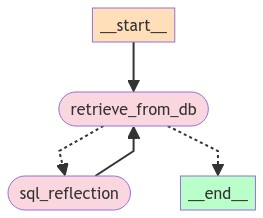

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
output_llama3 = graph.invoke({"messages": [("human", "Graph the total number of orders of each customer. X axis of the graph has to be in ascending order.")]})

-------------------------------------------------------
retrieve_from_db_model_llama3 :- ('human', 'Graph the total number of orders of each customer. X axis of the graph has to be in ascending order.')


retrieve_from_db_model_llama3 messages :- [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gyjh', 'function': {'arguments': '{"df_columns":["customer_id","count"],"df_name":"orders_per_customer","input_question":"Graph the total number of orders of each customer.","select_query":"SELECT customer_id, COUNT(*) AS count FROM orders GROUP BY customer_id ORDER BY customer_id ASC"}', 'name': 'create_df_from_sql'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 125, 'prompt_tokens': 1611, 'total_tokens': 1736, 'completion_time': 0.383162358, 'prompt_time': 0.333321868, 'queue_time': None, 'total_time': 0.716484226}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_c1a4bcec29', 'finish_reason': 'tool_calls', 'logprobs': None}, id=

In [15]:
print("=============================================")
print(output_llama3["messages"])

[('human', 'Graph the total number of orders of each customer. X axis of the graph has to be in ascending order.'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gyjh', 'function': {'arguments': '{"df_columns":["customer_id","count"],"df_name":"orders_per_customer","input_question":"Graph the total number of orders of each customer.","select_query":"SELECT customer_id, COUNT(*) AS count FROM orders GROUP BY customer_id ORDER BY customer_id ASC"}', 'name': 'create_df_from_sql'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 125, 'prompt_tokens': 1611, 'total_tokens': 1736, 'completion_time': 0.383162358, 'prompt_time': 0.333321868, 'queue_time': None, 'total_time': 0.716484226}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_c1a4bcec29', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-94a1e1ef-1a6b-4040-88f8-3f41611f78ef-0', tool_calls=[{'name': 'create_df_from_sql', 'args': {'df_columns': ['customer_id', 'cou